
<div style="
    background-color: #f7f7f7;
    background-image: url(''), url('') ;
    background-position: left bottom, right top;
    background-repeat: no-repeat,  no-repeat;
    background-size: auto 60px, auto 160px;
    border-radius: 5px;
    box-shadow: 0px 3px 1px -2px rgba(0, 0, 0, 0.2), 0px 2px 2px 0px rgba(0, 0, 0, 0.14), 0px 1px 5px 0px rgba(0,0,0,.12);">

<h1 style="
    color: #2a4cdf;
    font-style: normal;
    font-size: 2.25rem;
    line-height: 1.4em;
    font-weight: 600;
    padding: 30px 200px 0px 30px;"> 
        Compositional Based Property Prediction of Perovskites with CrabNet</h1>

<p style="
    line-height: 1.4em;
    padding: 30px 200px 0px 30px;">
    This notebook demonstrates how to use <a href="https://github.com/sparks-baird/CrabNet" target="_blank">CrabNet</a> to predict the bandgap of perovskites using data from the <a href="https://www.nature.com/articles/s41560-021-00941-3" target="_blank"><i>Perovskite Database</i></a> in NOMAD for training. The method can be extended to predict other properties of perovskites and can also be combined with other methodologies available in the community for this task. To explore more of these methodologies, we recommend taking a look at <a href="https://matbench.materialsproject.org/" target="_blank">MatBench</a>, a benchmarking suite for these tasks in the materials informatics community.
</p>

<p style="font-size: 1.25em; font-style: italic; padding: 5px 200px 30px 30px;">
    José A. Márquez, Siamak Nakhaie and Hampus Näsström
</p>
</div>

## Outline

- [Installations](#installations)
- [Retrieve Data using NOMAD API](#retrieve-data-using-nomad-api)
- [Save Data](#save-data)
- [Load data](#load-data)
- [EDA & Data Cleaning](#eda--data-cleaning)
  - [Insights from NOMAD GUI](#insights-from-nomad-gui)
  - [Remove NaNs](#remove-nans)
  - [Group Repeated Formulas](#group-repeated-formulas)
  - [Check Element Prevalence](#check-element-prevalence)
- [Build and Fit the Model](#build-and-fit-the-model)
- [Model evaluation](#model-evaluation)
- [Predict Bandgap from Individual Formulas](#predict-bandgap-from-individual-formulas)

## Installations

We will start by running a couple of pip installers. Skip this part if you have the libraries installed in your environment.

In [ ]:
! pip install torch
! pip install crabnet
! pip install pandas
! pip install jmespath

  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)


## Retrieve Data using NOMAD API

We will now fetch Perovskite solar cell data from the NOMAD API.  If you already have the data, the **perovskite_bandgap_devices.csv** in the **data** folder, you can skip this part, and continue with Loading Data. Note that calling the database through the API may take a while.

In [1]:
from time import monotonic

import jmespath
import requests

base_url = 'https://nomad-lab.eu/prod/v1/api/v1'
bandgaps = []
reduced_formulas = []
descriptive_formulas = []
page_after_value = None

def extract_values(entry):
    bandgaps.append(jmespath.search('results.properties.electronic.band_structure_electronic[0].band_gap[0].value', entry))
    reduced_formulas.append(jmespath.search('results.material.chemical_formula_reduced', entry))
    descriptive_formulas.append(jmespath.search('results.material.chemical_formula_descriptive', entry))


start = monotonic()
while True:

    response = requests.post(
        f'{base_url}/entries/query',
        json={
            "owner": "visible",
            "query": {
                "and": [
                    # {"results.material.elements:all": ["Sn"]},
                    {"sections:all": ["nomad.datamodel.results.SolarCell"]}
                ]
            },
            'pagination': {
                'page_size': 1000,
                'page_after_value': page_after_value
            }
        }
    )
    response_code = response.status_code
    data = response.json()
    pagination = data['pagination']
    if page_after_value is None:
        print(f'Total number of entries: {pagination["total"]}')
    print(response_code)
    page_after_value = data['pagination'].get('next_page_after_value')

    for entry in data['data']:
        extract_values(entry)
    if not page_after_value:
        break
    end = monotonic()

print(f'Query took {end - start:.2f} seconds')

Total number of entries: 43108
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
Query took 1213.75 seconds


You can verify that the data was fetched correctly by checking the length of of of the lists, e.g., bandgap

## Save Data

### Put Data into a Pandas DataFrame and Save

We can also have a quick look on the DataFrame, and change the units of the bandgap from J to eV. 

<div class="alert alert-block alert-info">
⚠️ The data in the `results` section of NOMAD is stored in SI units.
</div>

In [2]:
import os

import pandas as pd

df = pd.DataFrame({
    'reduced_formulas': reduced_formulas,
    'descriptive_formulas': descriptive_formulas,
    'bandgap': bandgaps,
    })

df['bandgap'] = pd.to_numeric(df['bandgap'], errors='coerce')
df['bandgap'] = df['bandgap']*6.24150974e18
df.head()

if not os.path.exists('data'):
    os.makedirs('data')
df.to_csv('data/perovskite_bandgap_devices.csv', index=False)

## Load data 

In the previous part, we retrieved perovskite solar cell data using the NOMAD API, converted it to a Pandas DataFrame, and saved it as **perovskite_bandgap_devices.csv** in the **data** folder. If you already have the data, you can start from this section, where we will import and clean it.

The distribution of the chemical diveristy of the dataset can be viewed in the dynamic periodioc table of the NOMAD entries explorer. The down right corner of every element shows the number of entries (solar cells) that contain in the absorber a given element. It becomes obvius that the data set is imbalance with the majority of the entries being *Pb* based, containing *C*, *N* anf *H* (hybrid perovskites) and mostly halide compounds, with most of the entries having *I* and/or *Br*. 

In [3]:
import pandas as pd

df = pd.read_csv('data/perovskite_bandgap_devices.csv')
df.head()

,reduced_formulas,descriptive_formulas,bandgap
0,CH6I3NPb,MAPbI3,1.6
1,CH6I3NPb,MAPbI3,NaN
2,CH6I3NPb,MAPbI3,1.5
3,CH6I3NPb,MAPbI3,1.6
4,CH6I3NPb,MAPbI3,1.6


## EDA & Data Cleaning

Exploratory Data Analysis (EDA) is a useful step in understanding and preparing datasets for modeling by summarizing data, checking for anomalies, finding patterns and relationships.

### Insights from NOMAD GUI

The distribution of chemical diversity of the dataset can be explored using the [periodic table in the NOMAD solar cell app](https://nomad-lab.eu/prod/v1/gui/search/solarcells). The bottom-right corner of each element displays the number of entries (solar cells) that include the element in the absorber. The dataset is notably imbalanced, with the majority of entries being Pb-based, containing C, N, H (hybrid perovskites), and halides like I and Br.

Let's have a look on the statistical summary of the dataset:

In [4]:
df.describe()

,bandgap
count,32454.000000
mean,1.610993
std,0.124426
min,1.160000
25%,1.600000
50%,1.600000
75%,1.600000
max,3.050000


We can see that the dataset contains a diverse range of bandgap values (1.16 to 3.05 eV). Some parameters such as open circuit voltage (voc) and fill factor (ff), include extreme or zero values, which might need attention for data cleaning.

### Remove NaNs

The dataset might include missing values, let's check if there are any:

In [5]:
df.isna().sum()

reduced_formulas          577
descriptive_formulas      577
bandgap                 10654
dtype: int64

 Let's now keep only the part of the dataframe, where the value for bandgap is not Na.

In [6]:
df = df[df['bandgap'].notna()]
df = df[df['reduced_formulas'].notna()]

In [7]:
df.isna().sum()

reduced_formulas        0
descriptive_formulas    0
bandgap                 0
dtype: int64

### Group Repeated Formulas

Even before checking the dataset, we can already guess that are many repeated formulas and bandgap values in the DataFrame. But let's verify it:

In [8]:
df['reduced_formulas'].value_counts().head(10)


reduced_formulas
CH6I3NPb                       26474
CH5I3N2Pb                        569
Br51C95Cs5H491I249N174Pb100      235
BrCsI2Pb                         230
Br9C20H103I51N37Pb20             215
Br2CsIPb                         171
CsI3Pb                           159
Br3CsPb                          141
Br3CH6NPb                        138
Br51C100H517I249N183Pb100        126
Name: count, dtype: int64

The dataset contains many repeated formulas and corresponding bandgap values. To make sure each formula is unique, we will use the `groupby_formula` function from CrabNet to group entries by their formulas and use the mean values for their bandgap. We make a new final DataFrame for our model, call it **df_reduced_formula** and adjust colum names etc.

Let's rename columns and use the `gourpby_formula` function from CrabNet:

In [9]:
from crabnet.utils.data import groupby_formula  # type: ignore

# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df.rename(columns={'bandgap': 'target'}, inplace=True)
df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the mean of the target
df_grouped_formula = groupby_formula(df, how='mean')
df_grouped_formula.head()


,formula,index,target
0,Ag20Bi20CsI60,"(124, 833, 3283, 10847, 18065, 18911, 21053, 2...",1.86
1,Ag20Bi60Cs3I170,"(9369,)",1.86
2,Ag2Bi3I11,"(80, 1749, 32848)",1.92
3,Ag2BiI5,"(11556, 12700, 42264)",2.10
4,Ag2CsI3Sb2,"(36218,)",1.96


Let's check the shape of the DataFrame we would like to use for our ML:

In [10]:
df_grouped_formula.shape


(998, 3)

### Check Element Prevalence 

We will use `pymatviz` ([link to docs](https://pymatviz.janosh.dev/)) for visualizing the element prevalence.

Run the following snippet if the package is not installed in the environment yet, otherwise skip it.

You can simply try:

In [11]:
! pip install pymatviz


in case of problems, try it from its developer repo:

! pip install git+https://github.com/janosh/pymatviz

Once installed, we import and use it:

In [14]:
from pymatviz import ptable_heatmap_plotly  # type: ignore

ptable_heatmap_plotly(df_grouped_formula['formula'], log=False, colorscale='BuPu', font_colors='black')
#, fmt='.3g')#, colorbar=dict(orientation="v", title= 'Element Prevalence'))

ValueError: Invalid property specified for object of type plotly.graph_objs.heatmap.ColorBar: 'titleside'

Did you mean "title"?

    Valid properties:
        bgcolor
            Sets the color of padded area.
        bordercolor
            Sets the axis line color.
        borderwidth
            Sets the width (in px) or the border enclosing this
            color bar.
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        labelalias
            Replacement text for specific tick or hover labels. For
            example using {US: 'USA', CA: 'Canada'} changes US to
            USA and CA to Canada. The labels we would have shown
            must match the keys exactly, after adding any
            tickprefix or ticksuffix. For negative numbers the
            minus sign symbol used (U+2212) is wider than the
            regular ascii dash. That means you need to use −1
            instead of -1. labelalias can be used with any axis
            type, and both keys (if needed) and values (if desired)
            can include html-like tags or MathJax.
        len
            Sets the length of the color bar This measure excludes
            the padding of both ends. That is, the color bar length
            is this length minus the padding on both ends.
        lenmode
            Determines whether this color bar's length (i.e. the
            measure in the color variation direction) is set in
            units of plot "fraction" or in *pixels. Use `len` to
            set the value.
        minexponent
            Hide SI prefix for 10^n if |n| is below this number.
            This only has an effect when `tickformat` is "SI" or
            "B".
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        orientation
            Sets the orientation of the colorbar.
        outlinecolor
            Sets the axis line color.
        outlinewidth
            Sets the width (in px) of the axis line.
        separatethousands
            If "true", even 4-digit integers are separated
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        thickness
            Sets the thickness of the color bar This measure
            excludes the size of the padding, ticks and labels.
        thicknessmode
            Determines whether this color bar's thickness (i.e. the
            measure in the constant color direction) is set in
            units of plot "fraction" or in "pixels". Use
            `thickness` to set the value.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the color bar's tick label font
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            A tuple of :class:`plotly.graph_objects.heatmap.colorba
            r.Tickformatstop` instances or dicts with compatible
            properties
        tickformatstopdefaults
            When used in a template (as layout.template.data.heatma
            p.colorbar.tickformatstopdefaults), sets the default
            property values to use for elements of
            heatmap.colorbar.tickformatstops
        ticklabeloverflow
            Determines how we handle tick labels that would
            overflow either the graph div or the domain of the
            axis. The default value for inside tick labels is *hide
            past domain*. In other cases the default is *hide past
            div*.
        ticklabelposition
            Determines where tick labels are drawn relative to the
            ticks. Left and right options are used when
            `orientation` is "h", top and bottom when `orientation`
            is "v".
        ticklabelstep
            Sets the spacing between tick labels as compared to the
            spacing between ticks. A value of 1 (default) means
            each tick gets a label. A value of 2 means shows every
            2nd label. A larger value n means only every nth tick
            is labeled. `tick0` determines which labels are shown.
            Not implemented for axes with `type` "log" or
            "multicategory", or when `tickmode` is "array".
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided).
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on Chart Studio Cloud for
            `ticktext`.
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on Chart Studio Cloud for
            `tickvals`.
        tickwidth
            Sets the tick width (in px).
        title
            :class:`plotly.graph_objects.heatmap.colorbar.Title`
            instance or dict with compatible properties
        x
            Sets the x position with respect to `xref` of the color
            bar (in plot fraction). When `xref` is "paper",
            defaults to 1.02 when `orientation` is "v" and 0.5 when
            `orientation` is "h". When `xref` is "container",
            defaults to 1 when `orientation` is "v" and 0.5 when
            `orientation` is "h". Must be between 0 and 1 if `xref`
            is "container" and between "-2" and 3 if `xref` is
            "paper".
        xanchor
            Sets this color bar's horizontal position anchor. This
            anchor binds the `x` position to the "left", "center"
            or "right" of the color bar. Defaults to "left" when
            `orientation` is "v" and "center" when `orientation` is
            "h".
        xpad
            Sets the amount of padding (in px) along the x
            direction.
        xref
            Sets the container `x` refers to. "container" spans the
            entire `width` of the plot. "paper" refers to the width
            of the plotting area only.
        y
            Sets the y position with respect to `yref` of the color
            bar (in plot fraction). When `yref` is "paper",
            defaults to 0.5 when `orientation` is "v" and 1.02 when
            `orientation` is "h". When `yref` is "container",
            defaults to 0.5 when `orientation` is "v" and 1 when
            `orientation` is "h". Must be between 0 and 1 if `yref`
            is "container" and between "-2" and 3 if `yref` is
            "paper".
        yanchor
            Sets this color bar's vertical position anchor This
            anchor binds the `y` position to the "top", "middle" or
            "bottom" of the color bar. Defaults to "middle" when
            `orientation` is "v" and "bottom" when `orientation` is
            "h".
        ypad
            Sets the amount of padding (in px) along the y
            direction.
        yref
            Sets the container `y` refers to. "container" spans the
            entire `height` of the plot. "paper" refers to the
            height of the plotting area only.
        
Did you mean "title"?

Bad property path:
titleside
^^^^^^^^^

As you can see the current data is heavily based on hybrid halide perovskites, so we expect the model to perform better when predicting these materials. Let's continue and build the model in the next section!

## Build and Fit the Model 

We randomize the dataset and split it into training, validation, and test sets in a ratio of 80%, 10%, and 10%, respectively.

In [15]:
import numpy as np

train_df, val_df, test_df = np.split(
    df_grouped_formula.sample(frac=1, random_state=42),
    [
        int(0.8 * len(df_grouped_formula)),
        int(0.9 * len(df_grouped_formula))
    ]
)

We then fit the model using the CrabNet implementation.

/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)




Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 798/798 [00:00<00:00, 106117.58formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 100/100 [00:00<00:00, 112147.17formulae/s]

loading data with up to 8 elements in the formula
stepping every 70 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.216 val mae: 0.182


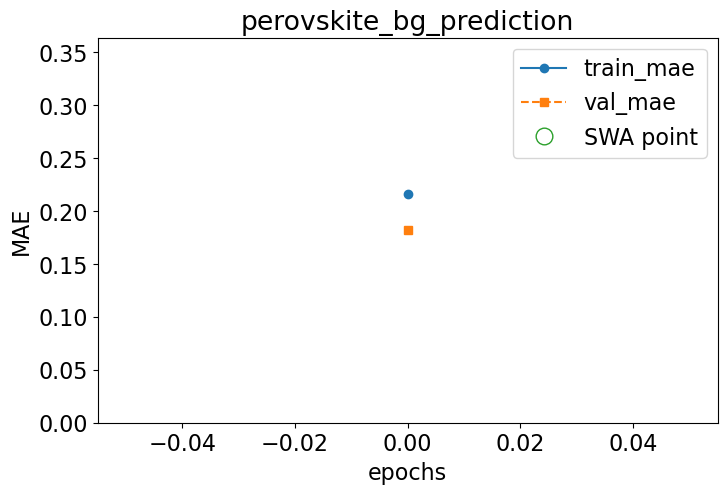

Epoch: 19/300 --- train mae: 0.0905 val mae: 0.105


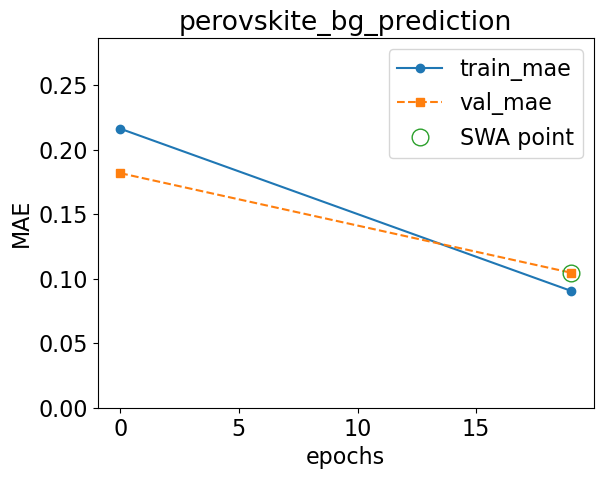

Epoch: 39/300 --- train mae: 0.0531 val mae: 0.0757


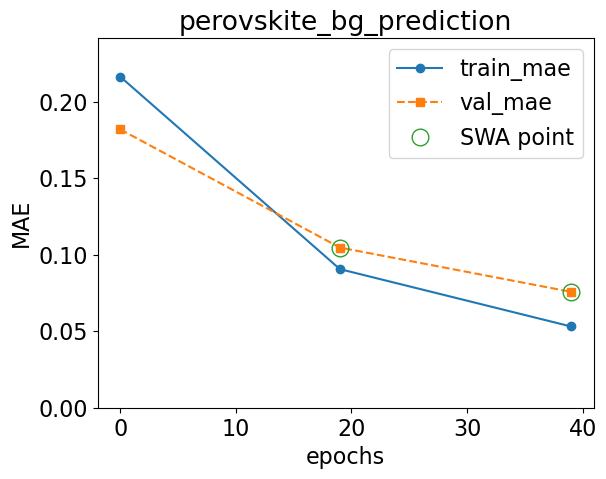

Epoch: 59/300 --- train mae: 0.0387 val mae: 0.0689


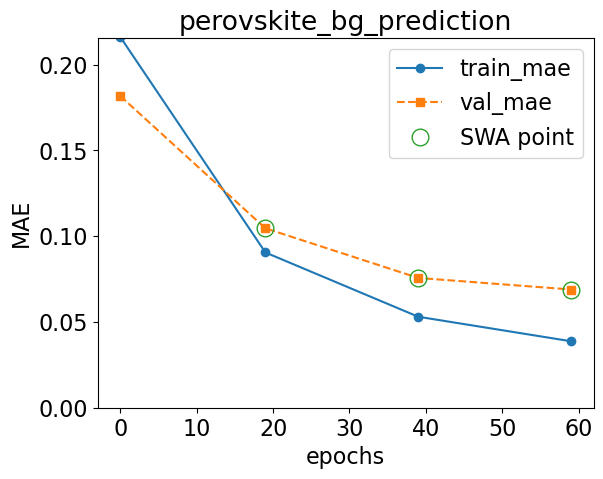

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0294 val mae: 0.0698


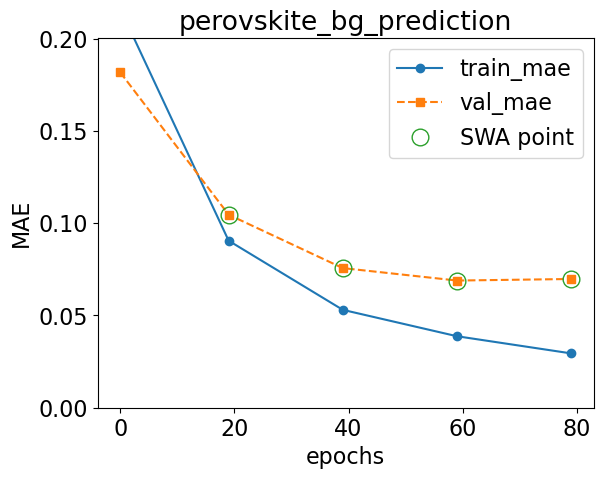

Epoch: 99/300 --- train mae: 0.0231 val mae: 0.0664


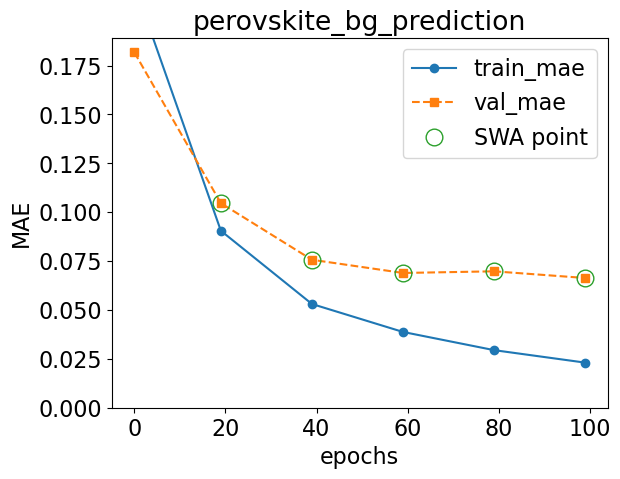

Epoch: 119/300 --- train mae: 0.02 val mae: 0.0654


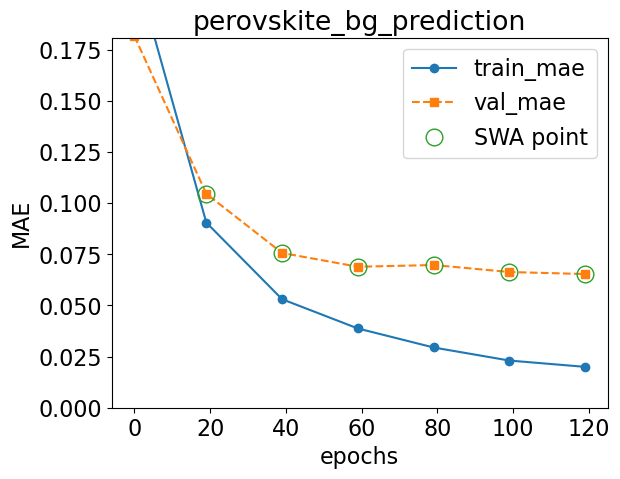

Epoch 139 failed to improve.
Discarded: 2/3 weight updates
Epoch: 139/300 --- train mae: 0.0159 val mae: 0.0688


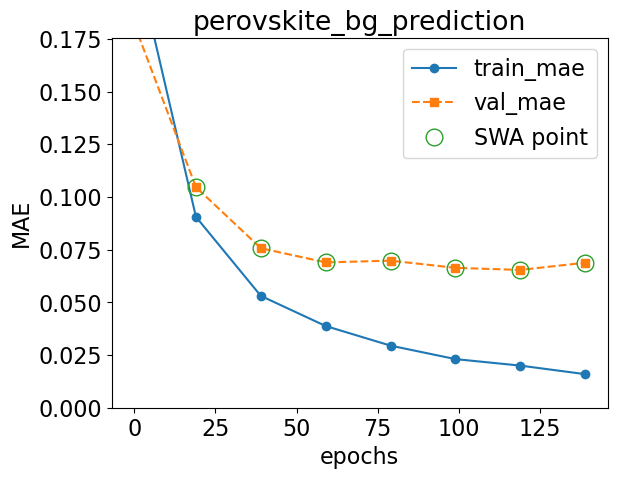

Epoch: 159/300 --- train mae: 0.0138 val mae: 0.0639


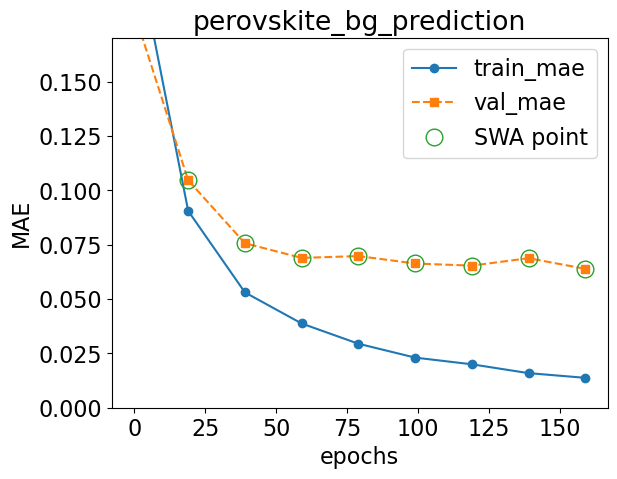

Epoch: 179/300 --- train mae: 0.0126 val mae: 0.0646


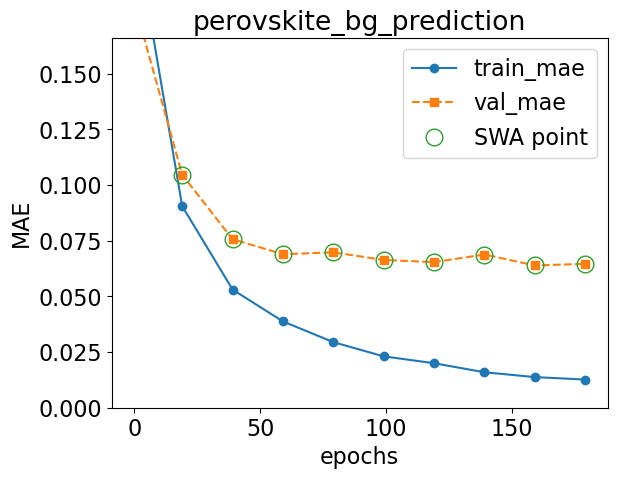

Epoch: 199/300 --- train mae: 0.0113 val mae: 0.0649


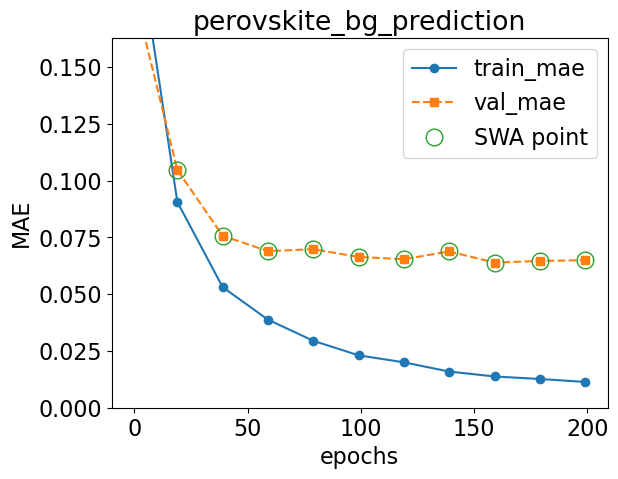

Epoch: 219/300 --- train mae: 0.0113 val mae: 0.0651


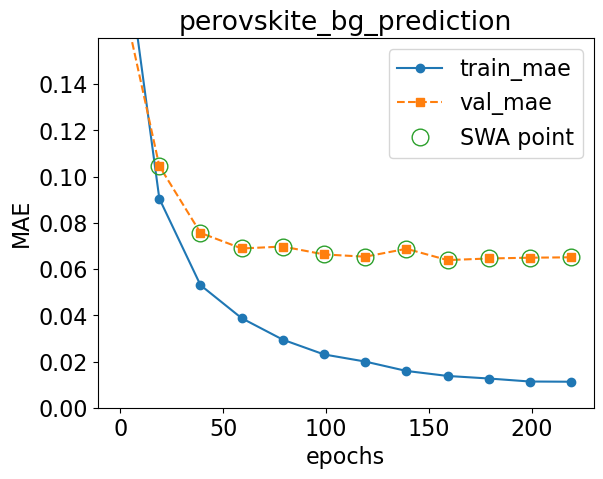

Epoch 239 failed to improve.
Discarded: 3/3 weight updates
Epoch: 239/300 --- train mae: 0.00949 val mae: 0.0652


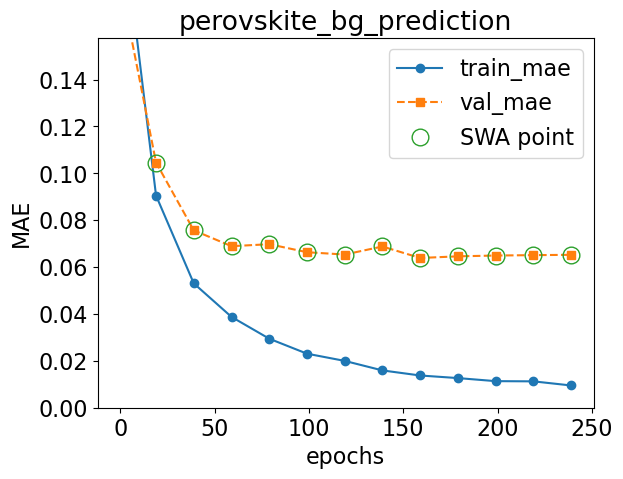

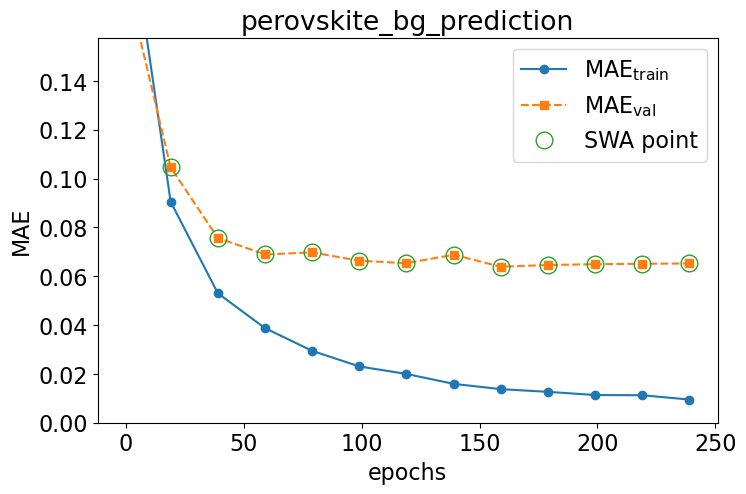

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction) to models/trained_models/perovskite_bg_prediction.pth


In [16]:
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction', elem_prop='mat2vec', learningcurve=True)
crabnet_bandgap.fit(train_df, val_df)

## Model evaluation

After training, we evaluate the model using the validation data.

Generating EDM: 100%|██████████| 798/798 [00:00<00:00, 111825.69formulae/s]


loading data with up to 8 elements in the formula


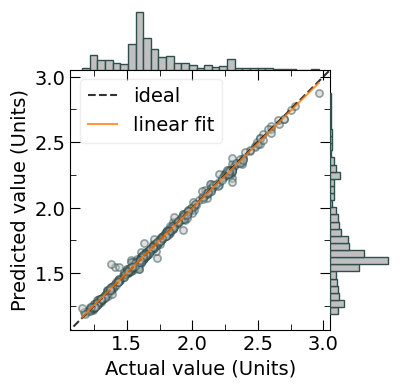

R2 score: 0.996240828559223
MSE: 0.00033687066910749426
MAE: 0.0096965625520289 eV


In [17]:
from crabnet.utils.figures import act_pred  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train data
train_df_zeros = pd.DataFrame({"formula": train_df['formula'], "target": [0.0]*len(train_df['formula'])})
train_df_predicted, train_df_predicted_sigma = crabnet_bandgap.predict(train_df_zeros, return_uncertainty=True)

act_pred(train_df['target'], train_df_predicted)
r2 = r2_score(train_df['target'], train_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(train_df['target'], train_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(train_df['target'], train_df_predicted)
print(f'MAE: {mae} eV')

for validation data we have:

Generating EDM: 100%|██████████| 100/100 [00:00<00:00, 108268.04formulae/s]


loading data with up to 8 elements in the formula


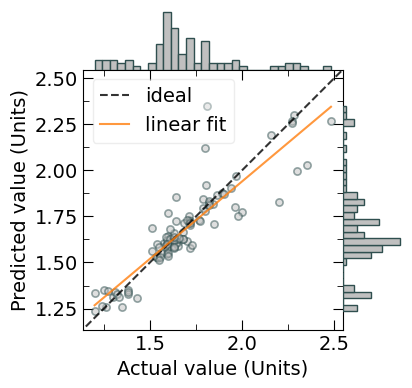

R2 score: 0.8062778833863574
MSE: 0.012223033066535778
MAE: 0.06424988428653577 eV


In [19]:
# Validation data
val_df_zeros = pd.DataFrame({"formula": val_df['formula'], "target": [0.0]*len(val_df['formula'])})
val_df_predicted, val_df_predicted_sigma = crabnet_bandgap.predict(val_df_zeros, return_uncertainty=True)

act_pred(val_df['target'], val_df_predicted)
r2 = r2_score(val_df['target'], val_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(val_df['target'], val_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(val_df['target'], val_df_predicted)
print(f'MAE: {mae} eV')

and finally for test data:

Generating EDM: 100%|██████████| 100/100 [00:00<00:00, 109226.67formulae/s]


loading data with up to 8 elements in the formula


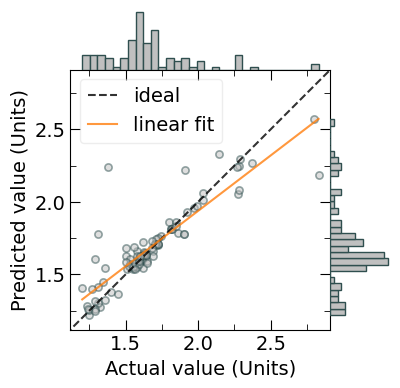

R2 score: 0.7738188863186181
MSE: 0.02071554936327003
MAE: 0.0705973793309228 eV


In [20]:
# Test data

test_df_zeros = pd.DataFrame({"formula": test_df['formula'], "target": [0.0]*len(test_df['formula'])})
test_df_predicted, test_df_predicted_sigma = crabnet_bandgap.predict(test_df_zeros, return_uncertainty=True)

act_pred(test_df['target'], test_df_predicted)

r2 = r2_score(test_df['target'], test_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(test_df['target'], test_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(test_df['target'], test_df_predicted)
print(f'MAE: {mae} eV')

## Predict Bandgap from Individual Formulas

Now we are ready to run some predictions using our trainned model. 
We will start loading the model just in case you want to start direcly here in a new session and the model weights are available.

In [22]:
import numpy as np
import pandas as pd  # only if you jump to this cell directly
from crabnet.crabnet_ import CrabNet  # type: ignore
from crabnet.kingcrab import SubCrab  # type: ignore

# Instantiate SubCrab
sub_crab_model = SubCrab()

# Instantiate CrabNet and set its model to SubCrab
crabnet_model = CrabNet()
crabnet_model.model = sub_crab_model

# Load the pre-trained network
file_path = r'perovskite_bg_prediction.pth'
crabnet_model.load_network(file_path)


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted

Then define a function and run it for predicting the bandgap from individual formulas:


In [23]:
# Function to predict the bandgap of a given formula
def predict_bandgap(formula):
    input_df = pd.DataFrame({"formula": [formula], "target": [0.0]})
    prediction, prediction_sigma = crabnet_bandgap.predict(input_df, return_uncertainty=True)
    return prediction, prediction_sigma

# Main script to take user input and display predictions
while True:
    formula = input("Enter a formula (e.g., CsPbBr3, CH3NH3PbI3) or type 'exit' to quit: ")
    if formula.lower() == 'exit':
        print("Exiting prediction tool. Goodbye!")
        break
    try:
        prediction, prediction_sigma = predict_bandgap(formula)
        print(f"Predicted bandgap: {np.round(prediction[0], 3)} +/- {np.round(prediction_sigma[0], 3)} eV")
    except Exception as e:
        print(f"Error during prediction: {e}")

Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15307.68formulae/s]


loading data with up to 8 elements in the formula
Predicted bandgap: 2.335 +/- 0.036 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15196.75formulae/s]


loading data with up to 8 elements in the formula
Predicted bandgap: 1.915 +/- 0.081 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16513.01formulae/s]


loading data with up to 8 elements in the formula
Predicted bandgap: 1.948 +/- 0.064 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11366.68formulae/s]


loading data with up to 8 elements in the formula
Predicted bandgap: 1.305 +/- 0.012 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16710.37formulae/s]


loading data with up to 8 elements in the formula
Predicted bandgap: 2.335 +/- 0.036 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/utils/utils.py:523: RuntimeWarning:

invalid value encountered in divide



loading data with up to 8 elements in the formula
Error during prediction: index 9223372036854775807 is out of bounds for dimension 0 with size 5000


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18001.30formulae/s]
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/utils/utils.py:523: RuntimeWarning:

invalid value encountered in divide



loading data with up to 8 elements in the formula
Error during prediction: index 9223372036854775807 is out of bounds for dimension 0 with size 5000


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17848.10formulae/s]
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/utils/utils.py:523: RuntimeWarning:

invalid value encountered in divide



loading data with up to 8 elements in the formula
Error during prediction: index 9223372036854775807 is out of bounds for dimension 0 with size 5000


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17697.49formulae/s]
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/utils/utils.py:523: RuntimeWarning:

invalid value encountered in divide



loading data with up to 8 elements in the formula
Error during prediction: index 9223372036854775807 is out of bounds for dimension 0 with size 5000


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/utils/utils.py:523: RuntimeWarning:

invalid value encountered in divide



loading data with up to 8 elements in the formula
Error during prediction: index 9223372036854775807 is out of bounds for dimension 0 with size 5000
Exiting prediction tool. Goodbye!


Alternatively, this interactive widget allows you to input a chemical formula, predict its bandgap using the trained model, and check if the formula exists in the dataset. If it does, the widget displays the average bandgap value used during training.

In [25]:
import numpy as np
import pandas as pd
from IPython.display import display
from ipywidgets import Button, HBox, Output, Text, VBox


# Function to predict the bandgap of a given formula
def predict_bandgap(formula):
    val_df = pd.DataFrame({"formula": [formula], "target": [0.0]})
    prediction, prediction_sigma = crabnet_bandgap.predict(val_df, return_uncertainty=True)
    return prediction, prediction_sigma

# Function to check if the formula exists in the dataset
def check_formula_in_dataset(formula):
    if formula in df_grouped_formula['formula'].values:
        avg_bandgap = df_grouped_formula.loc[
            df_grouped_formula['formula'] == formula, 'target'
        ].values[0]
        return avg_bandgap
    else:
        return None

# Setting up the widget interface
formula_input = Text(
    value='',
    placeholder='Enter formula (e.g., CsPbBr3)',
    description='Formula:',
)
predict_button = Button(description='Predict Bandgap', button_style='success')
output = Output()

def on_click(b):
    with output:
        output.clear_output()
        try:
            formula = formula_input.value.strip()
            if not formula:
                print("Please enter a valid chemical formula.")
                return

            # Prediction
            prediction, sigma = predict_bandgap(formula)
            print(f"Predicted Bandgap: {np.round(prediction[0], 3)} ± {np.round(sigma[0], 3)} eV")

            # Dataset check
            avg_bandgap = check_formula_in_dataset(formula)
            if avg_bandgap is not None:
                print(f"The averaged literature bandgap for {formula} is {avg_bandgap:.3f} eV (from dataset).")
            else:
                print(f"The formula '{formula}' is not contained in the dataset.")
        except Exception as e:
            print(f"Error: {e}")

predict_button.on_click(on_click)

display(VBox([HBox([formula_input, predict_button]), output]))

ModuleNotFoundError: No module named 'ipywidgets'